In [1]:
# MTH319 Tutorial No9

   Vasick Model:   
        short rate model:  dr(t) = a(b-r(t))*dt + sigma*dW
            
        forward rate model: dF(t,T)=sigma(t,T)*sigma*(t,T)dt + sigma(t,T)*dW
            diffusion:  
                          sigma(t,T) = exp(-a(T-t))*sigma
            drift: 
                          sigma(t,T)*sigma*(t,T) = sigma^2*(exp(-a(T-t))-exp(-2a(T-t)))

# Tasks
#       Conduct a Monte Carlo simulation for forward rates implied from Vasicek Model
#       Estimate the dynamics of bond prices, yields over time with simulated forward rate paths
#       Compare the bond prices estimated using short-rates and forward Estimate the dynamics of yields over time with simulated rate paths



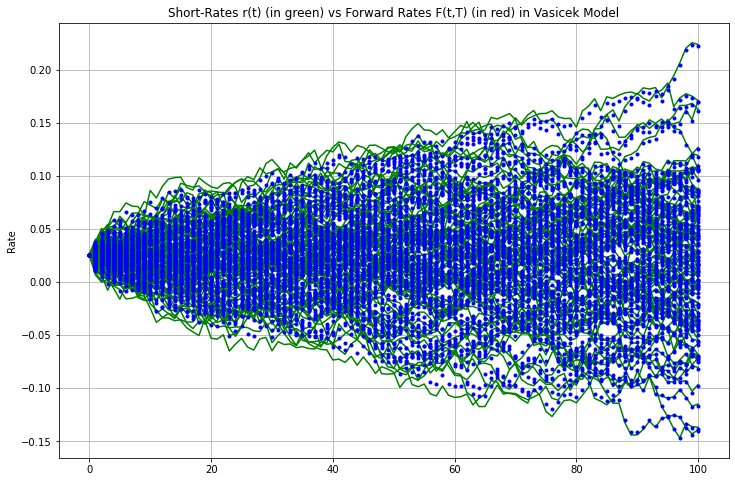

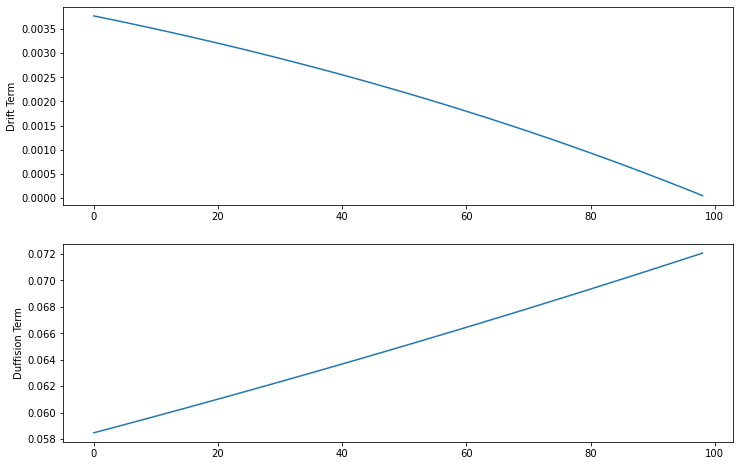

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def EulerMCShortRates(parameters):
    np.random.seed(1000)

    # time setup
    #T = parameters['setup']['T']  # total time/maturity
    numSteps = parameters['setup']['numSteps']  # number of steps
    numPaths = parameters['setup']['numPaths']  # number of simulated paths
    dt = parameters['setup']['dt']

    # model parameters
    m_name = parameters['model']['name']
    r_0 = parameters['model']['r0']  # initial value
    a = parameters['model']['a']
    b = parameters['model']['b']
    sigma = parameters['model']['sigma']  # initial value
    
    # simulation    
    r = np.zeros((numSteps + 1, numPaths),dtype=float)
    r[0,:] = r_0
  
    ################         simluations for short rate r(t)              ########
    for i in range(numPaths):
        for t_step in range(1, numSteps+1):
            Zs = np.random.normal(0, 1, 1)  
            
            if m_name == 'Vasicek':
                r[t_step,i] = r[t_step-1,i] + a*(b-r[t_step-1,i])*dt + sigma*np.sqrt(dt)*Zs # Vasicek model with Euler shceme
            elif m_name == 'CIR':
                r[t_step,i] = r[t_step-1,i] + a*(b-r[t_step-1,i])*dt + sigma*np.sqrt(r[t_step-1,i]*dt)*Zs # CIR model with Euler shceme
            
    return r


def EulerMCForwardRates(parameters):
    np.random.seed(1000)

    # time setup
    T = parameters['setup']['T']  # total time/maturity
    numSteps = parameters['setup']['numSteps']  # number of steps
    numPaths = parameters['setup']['numPaths']  # number of simulated paths
    dt = parameters['setup']['dt']

    # model parameters
    m_name = parameters['model']['name']
    r_0 = parameters['model']['r0']  # initial value
    a = parameters['model']['a']
    b = parameters['model']['b']
    sigma = parameters['model']['sigma']  # initial value
    
    # simulation    
    f_rate = np.zeros((numSteps + 1, numPaths),dtype=float)
    f_rate[0,:] = r_0 # r(t,t) = F(t,t)
    
    diffusion = np.zeros((numSteps+1,1), dtype = float)#===> change of time--> vector
    drift = np.zeros((numSteps+1,1), dtype = float)
  
    ################         simluations for short rate r(t)              ########
    for i in range(numPaths):
        for t_step in range(1, numSteps+1):
            Zs = np.random.normal(0, 1, 1)  
            
            if m_name == 'Vasicek':
                # work out diffusion and drift
                tau = T- t_step*dt
                
                item1 = np.exp(-a*tau)
                item2 = np.exp(-2*a*tau)
                diffusion[t_step][0] = sigma*item1
                drift[t_step][0] = (sigma**2/a)*(item1-item2)
                
                # Vasicek model with Euler shceme
                f_rate[t_step,i] = f_rate[t_step-1,i] + drift[t_step][0]*dt + diffusion[t_step][0]*np.sqrt(dt)*Zs 
                 #f_rate[t_step][i]
            
    return f_rate, drift, diffusion

# main function
if __name__ == '__main__':

    # initial value
    r0 = 0.0257
    
    # model parameters
    # a*b>= sigma^2/2 to ensure positivity of short rates
    m_name = 'Vasicek'  # 'CIR'
    a = 0.2134
    b = 0.0441
    sigma = 0.07222        
    
    # discrete setup
    T = 1     # maturity
    N = 100  # steps
    dt = T/N
    M = 100
    
    parameters = {'model':{'r0':r0, 'a':a, 'b':b, 'sigma':sigma, 'name':m_name}, 
                  'setup':{'T':T, 'numSteps':N, 'dt': T/N, 'numPaths':M}                
                 }
    # Conduct a standard Monte Carlo simulation for short-rates in Vasicek Model
    MC_short_rates = EulerMCShortRates(parameters)  # Steps X Paths
    #print(MC_short_rates)
    rs_df = pd.DataFrame(MC_short_rates)
    rs_df.to_csv("MC_short_rates.csv")
    
    
    
    
    #############################################################################
    #-------forward rate------------------------------------#
    #       Conduct a standard Monte Carlo simulation for Vasicek Model and CIR model
    [MC_forward_rates, drift, diffusion] = EulerMCForwardRates(parameters)  # Steps X Paths
    #print(MC_forward_rates)
    rs_df = pd.DataFrame(MC_forward_rates)
    rs_df.to_csv("MC_forward_rates.csv")
    
    
    
    
    
    
    ################----plot result#######################################
    # Plot all results related to forward-rate model specification
    plt.figure(figsize=(12, 8))
    plt.title('Short-Rates r(t) (in green) vs Forward Rates F(t,T) (in red) in Vasicek Model')
    plt.plot(MC_short_rates, 'g', label='r(t)')  # times short-rates paths
    plt.plot(MC_forward_rates,'b.', label='F(t,T)')  # times forward-rate paths
    #plt.legend(loc=0)
    plt.grid(True)
    #plt.xlabel('paths')
    plt.ylabel('Rate')  
    plt.savefig('forward-short-v-low.png')

    
    plt.figure(figsize=(12, 8)) 
    plt.subplot(2, 1, 1)
    plt.plot(drift[1:-1])  # time series of drift terms over time by ingoring the first one 
    plt.ylabel('Drift Term')
    
    plt.subplot(2, 1, 2)
    plt.plot(diffusion[1:-1])  # time series of diffusion terms over time by ingoring the first one 
    plt.ylabel('Duffision Term')
    #---------------------------------------------------------------------------------------#
    #---the difusion term will increase over time is due to the comprise of "r(t)=F(t,T)----"
    #----------------------------------------------------------------------------------------#
    plt.show() 
  

In [3]:
def TermStructure_Giventime(Rates_time_t, T_Maturity, parameters):
    
    numSteps = parameters['setup']['numSteps']  # number of steps
    numPaths = parameters['setup']['numPaths']  # number of simulated paths
    dt = parameters['setup']['dt']

    # model parameters
    m_name = parameters['model']['name']
    a = parameters['model']['a']
    b = parameters['model']['b']
    sigma = parameters['model']['sigma']  # initial value

    numSteps = parameters['setup']['numSteps']  # number of steps
    numPaths = parameters['setup']['numPaths']  # number of simulated paths
    dt = parameters['setup']['dt']
    
    n = len(T_Maturity)
    num_t = len(Rates_time_t)

    TS_yields = np.zeros((num_t, n))

    for t  in range(num_t):
        r_t = Rates_time_t[t]
        for T_i in T_Maturity:  # range(1,size(T))
            if T_i == 0:
                TS_yields[t][0] = r_t
            else:
                tao_j = T_i  # in year
                
                if m_name == 'Vasicek':
                    gamma = a**2*b - sigma**2/2
                    B = (1-np.exp(-a*tao_j))/a
                    A = (B-tao_j)*gamma/a - sigma**2*B**2/(4*a)            
                elif m_name == 'CIR':
                    gamma = np.sqrt(a** 2 + 2 * sigma ** 2)            
                    B = 2 * (np.exp(gamma * tao_j) - 1) / (
                                 (gamma + a) * (np.exp(gamma * tao_j) - 1) + 2 * gamma)
                    A = np.log(np.power(2 * gamma * np.exp((gamma + a) * tao_j / 2) / ((gamma + a) *
                                       (np.exp(gamma * tao_j) - 1) + 2 * gamma), 2 * a *b / (sigma ** 2)))
                
                TS_yields[t][T_Maturity.index(T_i)] = -(A - B * r_t) / tao_j
    
    return TS_yields

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def EulerMCShortRates(parameters):
    np.random.seed(1000)

    # time setup
    #T = parameters['setup']['T']  # total time/maturity
    numSteps = parameters['setup']['numSteps']  # number of steps
    numPaths = parameters['setup']['numPaths']  # number of simulated paths
    dt = parameters['setup']['dt']

    # model parameters
    m_name = parameters['model']['name']
    r_0 = parameters['model']['r0']  # initial value
    a = parameters['model']['a']
    b = parameters['model']['b']
    sigma = parameters['model']['sigma']  # initial value
    
    # simulation    
    r = np.zeros((numSteps + 1, numPaths),dtype=float)
    r[0,:] = r_0
  
    ################         simluations for short rate r(t)              ########
    for i in range(numPaths):
        for t_step in range(1, numSteps+1):
            Zs = np.random.normal(0, 1, 1)  
            
            if m_name == 'Vasicek':
                r[t_step,i] = r[t_step-1,i] + a*(b-r[t_step-1,i])*dt + sigma*np.sqrt(dt)*Zs # Vasicek model with Euler shceme
            elif m_name == 'CIR':
                r[t_step,i] = r[t_step-1,i] + a*(b-r[t_step-1,i])*dt + sigma*np.sqrt(r[t_step-1,i]*dt)*Zs # CIR model with Euler shceme
            
    return r


def EulerMCForwardRates(parameters):
    np.random.seed(1000)

    # time setup
    T = parameters['setup']['T']  # total time/maturity
    numSteps = parameters['setup']['numSteps']  # number of steps
    numPaths = parameters['setup']['numPaths']  # number of simulated paths
    dt = parameters['setup']['dt']

    # model parameters
    m_name = parameters['model']['name']
    r_0 = parameters['model']['r0']  # initial value
    a = parameters['model']['a']
    b = parameters['model']['b']
    sigma = parameters['model']['sigma']  # initial value
    
    # simulation    
    f_rate = np.zeros((numSteps + 1, numPaths),dtype=float)
    f_rate[0,:] = r_0 # r(t,t) = F(t,t)
    
    diffusion = np.zeros((numSteps+1,1), dtype = float)#===> change of time--> vector
    drift = np.zeros((numSteps+1,1), dtype = float)
  
    ################         simluations for short rate r(t)              ########
    for i in range(numPaths):
        for t_step in range(1, numSteps+1):
            Zs = np.random.normal(0, 1, 1)  
            
            if m_name == 'Vasicek':
                # work out diffusion and drift
                tau = T- t_step*dt
                
                item1 = np.exp(-a*tau)
                item2 = np.exp(-2*a*tau)
                diffusion[t_step][0] = sigma*item1
                drift[t_step][0] = (sigma**2/a)*(item1-item2)
                
                # Vasicek model with Euler shceme
                f_rate[t_step,i] = f_rate[t_step-1,i] + drift[t_step][0]*dt + diffusion[t_step][0]*np.sqrt(dt)*Zs 
                 #f_rate[t_step][i]
            
    return f_rate

# main function
if __name__ == '__main__':

    # initial value
    r0 = 0.02
    
    # model parameters
    # a*b>= sigma^2/2 to ensure positivity of short rates
    m_name = 'Vasicek'  #'Vasicek'
    a = 0.65
    b = 0.03
    sigma = 0.10        
    
    # discrete setup
    T = 1     # maturity
    N = 100  # steps
    dt = T/N
    M = 100
    
    parameters = {'model':{'r0':r0, 'a':a, 'b':b, 'sigma':sigma, 'name':m_name}, 
                  'setup':{'T':T, 'numSteps':N, 'dt': T/N, 'numPaths':M}                
                 }
    
     #       Estimate the term structure of yileds at time 0<t<T, given T=[0.5, 1, 3, 5, 10, 15, 20, 25, 30]    
    Terms = ['0', '0.5', '1', '3', '5', '10', '15', '20', '25', '30']
    T_Maturity = list(map(float, Terms))
    N_t = 50
    
    Rates_t = np.transpose(EulerMCForwardRates)[:,N_t]   # now Paths x Steps
    #print(Rates_t)
    TS_yields = TermStructure_Giventime(Rates_t, T_Maturity, parameters)
    #print(TS_yields)
    
    rs_df = pd.DataFrame(TS_yields)
    plt.figure(figsize=(12, 8))
    
    #plt.plot(T_Maturity,TS_yields)
    plt.plot(T_Maturity, np.transpose(TS_yields))

    plt.xlabel('Time to Maturity (T-t)')
    plt.ylabel('Term Structure of Yields')
    plt.title('Term Structure of Yields for Vasicek Model')

    plt.show()

IndexError: too many indices for array